In [1]:
import s3fs
import xarray as xr
import numpy as np
import pickle
import os
import gzip

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)

output_dir = "/home/data/lab_project2/Steve/model_runs/dry_land/scratch/"
base_path = "climt-long-runs/dry-land/regrid-data/"

In [2]:

def compute_threshold():
    
    lat_c=[20,25,30,35,40,45,50,55,60]
#     lat_c=[20, 25, 30]
    thresh={}
    
    for l in lat_c:
        print(l)
        
        t_all=[]
        for r in range(1,11):
            t_run=[]
            for y in range(1,21):

                # Path inside the bucket to your Zarr store
                zarr_path = base_path+"run"+str(r)+"/year"+str(y)
                ds = xr.open_zarr(fs.get_mapper(zarr_path))

                t_run.append(ds['air_temperature'].sel({'lev': 98000, 'lat':slice(l+5, l-5), 'lon':slice(100, 110)}))
        
            t_run=xr.merge(t_run, compat='no_conflicts', join='outer')
            t_run=t_run.weighted(t_run.lat).mean(dim=('lat', 'lon'))
            t_all.append(t_run)

        thresh[l]=xr.concat(t_all, dim="run")['air_temperature'].quantile(0.95, dim=('run', 'time')).compute().item()
    
    print(thresh)
    output_file=output_dir+'thresh95'
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(thresh, f)

        
compute_threshold()

20
25
30
35
40
45
50
55
60
{20: 303.02078690398235, 25: 303.53046081646124, 30: 301.79567322314597, 35: 300.2482790262102, 40: 297.4849430301182, 45: 294.8384345056472, 50: 291.5249345983152, 55: 287.8429001209907, 60: 284.7208178303385}


In [18]:
output_file=output_dir+'thresh95'
with open(output_file, 'rb') as f:
    thresh=pickle.load(f)
# print(thresh)

def identify_heatwaves(latc):
    
    hw_index=1
    hw_master={'index':[],'run':[],'time':[], 'T':[], 'lonc':[],
              'intensity':[], 'duration':[], 'maximum':[]}
    lon_ind=np.arange(36)*10+5
    
    #for ln in lon_ind[:]:        
    for r in range(1,11):
        t_run_all=[]
        for y in range(1,21):

            # Path inside the bucket to your Zarr store
            zarr_path = base_path+"run"+str(r)+"/year"+str(y)
            ds = xr.open_zarr(fs.get_mapper(zarr_path))
            t_run_all.append(ds['air_temperature'].sel({'lev': 98000, 'lat':slice(latc+5, latc-5)}))

        t_run_all=xr.concat(t_run_all, dim='time')
        t_run_all = t_run_all.weighted(t_run_all.lat).mean(dim='lat') - thresh[latc]
        
        for ln in lon_ind[:]:
            t_run = t_run_all.sel({'lon':slice(ln-5,ln+5)}).mean(dim='lon')
            # for loop to find heatwaves - there may be a better way to do this!
            
            T = t_run.values
            times = t_run.time.values
            
            temp_time=[]
            temp_intensity=[]
            l_curr=0
            for i in range(len(T)):
                if T[i]>0 and i!=0:
                    if len(temp_time)==0:
                        temp_time.append(times[i-1]); temp_intensity.append(T[i-1]) 
                    temp_time.append(times[i]); temp_intensity.append(T[i]) 
                    l_curr=l_curr+1
                else:
                    if l_curr>=3:
                        temp_time.append(times[i]); temp_intensity.append(T[i]) 
                        
                        heat=np.array(temp_intensity, dtype=float)

                        st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                        heat[0]=0;heat[-1]=0
                        dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                        intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                        mx=np.max(heat[1:-1])
                        dur=len(heat[1:-1])-1+st+end

                        if dur>=3:
                            print(f'run{r} lonc{ln} index{hw_index}')
                            hw_master['index'].append(hw_index)
                            hw_master['run'].append(r)
                            hw_master['time'].append(temp_time)
                            hw_master['T'].append(temp_intensity)
                            hw_master['intensity'].append(intensity.item())
                            hw_master['duration'].append(dur.item())
                            hw_master['maximum'].append(mx.item())
                            hw_master['lonc'].append(ln.item())
                            hw_index=hw_index+1

                    l_curr=0
                    temp_intensity=[]
                    temp_time=[]
                    
    print(hw_master['index'][-1])
    output_file=output_dir+'hw_'+str(latc)
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(hw_master, f)

identify_heatwaves(45)

run1 lonc5 index1
run1 lonc5 index2
run1 lonc5 index3
run1 lonc5 index4
run1 lonc5 index5
run1 lonc5 index6
run1 lonc5 index7
run1 lonc5 index8
run1 lonc5 index9
run1 lonc5 index10
run1 lonc5 index11
run1 lonc5 index12
run1 lonc5 index13
run1 lonc5 index14
run1 lonc5 index15
run1 lonc5 index16
run1 lonc5 index17
run1 lonc5 index18
run1 lonc5 index19
run1 lonc5 index20
run1 lonc5 index21
run1 lonc5 index22
run1 lonc5 index23
run1 lonc5 index24
run1 lonc5 index25
run1 lonc5 index26
run1 lonc5 index27
run1 lonc5 index28
run1 lonc5 index29
run1 lonc5 index30
run1 lonc5 index31
run1 lonc5 index32
run1 lonc5 index33
run1 lonc5 index34
run1 lonc15 index35
run1 lonc15 index36
run1 lonc15 index37
run1 lonc15 index38
run1 lonc15 index39
run1 lonc15 index40
run1 lonc15 index41
run1 lonc15 index42
run1 lonc15 index43
run1 lonc15 index44
run1 lonc15 index45
run1 lonc15 index46
run1 lonc15 index47
run1 lonc15 index48
run1 lonc15 index49
run1 lonc15 index50
run1 lonc15 index51
run1 lonc15 index52
run

run1 lonc145 index404
run1 lonc145 index405
run1 lonc145 index406
run1 lonc145 index407
run1 lonc145 index408
run1 lonc145 index409
run1 lonc145 index410
run1 lonc145 index411
run1 lonc145 index412
run1 lonc145 index413
run1 lonc145 index414
run1 lonc145 index415
run1 lonc145 index416
run1 lonc145 index417
run1 lonc145 index418
run1 lonc145 index419
run1 lonc145 index420
run1 lonc145 index421
run1 lonc145 index422
run1 lonc145 index423
run1 lonc145 index424
run1 lonc145 index425
run1 lonc145 index426
run1 lonc145 index427
run1 lonc155 index428
run1 lonc155 index429
run1 lonc155 index430
run1 lonc155 index431
run1 lonc155 index432
run1 lonc155 index433
run1 lonc155 index434
run1 lonc155 index435
run1 lonc155 index436
run1 lonc155 index437
run1 lonc155 index438
run1 lonc155 index439
run1 lonc155 index440
run1 lonc155 index441
run1 lonc155 index442
run1 lonc155 index443
run1 lonc155 index444
run1 lonc155 index445
run1 lonc155 index446
run1 lonc155 index447
run1 lonc155 index448
run1 lonc1

run1 lonc295 index799
run1 lonc295 index800
run1 lonc295 index801
run1 lonc295 index802
run1 lonc295 index803
run1 lonc295 index804
run1 lonc295 index805
run1 lonc295 index806
run1 lonc295 index807
run1 lonc295 index808
run1 lonc295 index809
run1 lonc295 index810
run1 lonc295 index811
run1 lonc295 index812
run1 lonc295 index813
run1 lonc295 index814
run1 lonc295 index815
run1 lonc295 index816
run1 lonc295 index817
run1 lonc295 index818
run1 lonc295 index819
run1 lonc295 index820
run1 lonc295 index821
run1 lonc295 index822
run1 lonc295 index823
run1 lonc295 index824
run1 lonc295 index825
run1 lonc305 index826
run1 lonc305 index827
run1 lonc305 index828
run1 lonc305 index829
run1 lonc305 index830
run1 lonc305 index831
run1 lonc305 index832
run1 lonc305 index833
run1 lonc305 index834
run1 lonc305 index835
run1 lonc305 index836
run1 lonc305 index837
run1 lonc305 index838
run1 lonc305 index839
run1 lonc305 index840
run1 lonc305 index841
run1 lonc305 index842
run1 lonc305 index843
run1 lonc3

run2 lonc65 index1186
run2 lonc65 index1187
run2 lonc65 index1188
run2 lonc65 index1189
run2 lonc65 index1190
run2 lonc65 index1191
run2 lonc65 index1192
run2 lonc65 index1193
run2 lonc65 index1194
run2 lonc65 index1195
run2 lonc65 index1196
run2 lonc65 index1197
run2 lonc65 index1198
run2 lonc65 index1199
run2 lonc65 index1200
run2 lonc65 index1201
run2 lonc65 index1202
run2 lonc65 index1203
run2 lonc65 index1204
run2 lonc65 index1205
run2 lonc65 index1206
run2 lonc65 index1207
run2 lonc65 index1208
run2 lonc65 index1209
run2 lonc65 index1210
run2 lonc65 index1211
run2 lonc65 index1212
run2 lonc65 index1213
run2 lonc65 index1214
run2 lonc65 index1215
run2 lonc65 index1216
run2 lonc65 index1217
run2 lonc65 index1218
run2 lonc65 index1219
run2 lonc65 index1220
run2 lonc65 index1221
run2 lonc65 index1222
run2 lonc65 index1223
run2 lonc65 index1224
run2 lonc75 index1225
run2 lonc75 index1226
run2 lonc75 index1227
run2 lonc75 index1228
run2 lonc75 index1229
run2 lonc75 index1230
run2 lonc7

run2 lonc195 index1578
run2 lonc195 index1579
run2 lonc195 index1580
run2 lonc195 index1581
run2 lonc195 index1582
run2 lonc195 index1583
run2 lonc195 index1584
run2 lonc195 index1585
run2 lonc195 index1586
run2 lonc195 index1587
run2 lonc195 index1588
run2 lonc195 index1589
run2 lonc195 index1590
run2 lonc195 index1591
run2 lonc195 index1592
run2 lonc195 index1593
run2 lonc195 index1594
run2 lonc195 index1595
run2 lonc195 index1596
run2 lonc195 index1597
run2 lonc195 index1598
run2 lonc195 index1599
run2 lonc195 index1600
run2 lonc195 index1601
run2 lonc195 index1602
run2 lonc195 index1603
run2 lonc195 index1604
run2 lonc195 index1605
run2 lonc195 index1606
run2 lonc195 index1607
run2 lonc195 index1608
run2 lonc205 index1609
run2 lonc205 index1610
run2 lonc205 index1611
run2 lonc205 index1612
run2 lonc205 index1613
run2 lonc205 index1614
run2 lonc205 index1615
run2 lonc205 index1616
run2 lonc205 index1617
run2 lonc205 index1618
run2 lonc205 index1619
run2 lonc205 index1620
run2 lonc20

run2 lonc315 index1942
run2 lonc315 index1943
run2 lonc315 index1944
run2 lonc315 index1945
run2 lonc315 index1946
run2 lonc315 index1947
run2 lonc315 index1948
run2 lonc315 index1949
run2 lonc315 index1950
run2 lonc315 index1951
run2 lonc315 index1952
run2 lonc315 index1953
run2 lonc315 index1954
run2 lonc315 index1955
run2 lonc315 index1956
run2 lonc315 index1957
run2 lonc315 index1958
run2 lonc315 index1959
run2 lonc315 index1960
run2 lonc315 index1961
run2 lonc315 index1962
run2 lonc315 index1963
run2 lonc315 index1964
run2 lonc315 index1965
run2 lonc315 index1966
run2 lonc315 index1967
run2 lonc315 index1968
run2 lonc315 index1969
run2 lonc315 index1970
run2 lonc315 index1971
run2 lonc315 index1972
run2 lonc315 index1973
run2 lonc325 index1974
run2 lonc325 index1975
run2 lonc325 index1976
run2 lonc325 index1977
run2 lonc325 index1978
run2 lonc325 index1979
run2 lonc325 index1980
run2 lonc325 index1981
run2 lonc325 index1982
run2 lonc325 index1983
run2 lonc325 index1984
run2 lonc32

run3 lonc75 index2322
run3 lonc75 index2323
run3 lonc75 index2324
run3 lonc75 index2325
run3 lonc75 index2326
run3 lonc75 index2327
run3 lonc75 index2328
run3 lonc75 index2329
run3 lonc75 index2330
run3 lonc75 index2331
run3 lonc75 index2332
run3 lonc75 index2333
run3 lonc75 index2334
run3 lonc75 index2335
run3 lonc75 index2336
run3 lonc75 index2337
run3 lonc75 index2338
run3 lonc75 index2339
run3 lonc75 index2340
run3 lonc75 index2341
run3 lonc75 index2342
run3 lonc75 index2343
run3 lonc85 index2344
run3 lonc85 index2345
run3 lonc85 index2346
run3 lonc85 index2347
run3 lonc85 index2348
run3 lonc85 index2349
run3 lonc85 index2350
run3 lonc85 index2351
run3 lonc85 index2352
run3 lonc85 index2353
run3 lonc85 index2354
run3 lonc85 index2355
run3 lonc85 index2356
run3 lonc85 index2357
run3 lonc85 index2358
run3 lonc85 index2359
run3 lonc85 index2360
run3 lonc85 index2361
run3 lonc85 index2362
run3 lonc85 index2363
run3 lonc95 index2364
run3 lonc95 index2365
run3 lonc95 index2366
run3 lonc9

run3 lonc205 index2711
run3 lonc205 index2712
run3 lonc205 index2713
run3 lonc205 index2714
run3 lonc205 index2715
run3 lonc205 index2716
run3 lonc205 index2717
run3 lonc205 index2718
run3 lonc205 index2719
run3 lonc205 index2720
run3 lonc205 index2721
run3 lonc205 index2722
run3 lonc205 index2723
run3 lonc205 index2724
run3 lonc205 index2725
run3 lonc205 index2726
run3 lonc205 index2727
run3 lonc205 index2728
run3 lonc205 index2729
run3 lonc205 index2730
run3 lonc205 index2731
run3 lonc205 index2732
run3 lonc205 index2733
run3 lonc205 index2734
run3 lonc205 index2735
run3 lonc205 index2736
run3 lonc205 index2737
run3 lonc205 index2738
run3 lonc205 index2739
run3 lonc205 index2740
run3 lonc205 index2741
run3 lonc205 index2742
run3 lonc205 index2743
run3 lonc205 index2744
run3 lonc205 index2745
run3 lonc205 index2746
run3 lonc205 index2747
run3 lonc205 index2748
run3 lonc215 index2749
run3 lonc215 index2750
run3 lonc215 index2751
run3 lonc215 index2752
run3 lonc215 index2753
run3 lonc21

run3 lonc325 index3090
run3 lonc325 index3091
run3 lonc325 index3092
run3 lonc325 index3093
run3 lonc325 index3094
run3 lonc325 index3095
run3 lonc325 index3096
run3 lonc325 index3097
run3 lonc325 index3098
run3 lonc325 index3099
run3 lonc325 index3100
run3 lonc325 index3101
run3 lonc325 index3102
run3 lonc325 index3103
run3 lonc325 index3104
run3 lonc325 index3105
run3 lonc325 index3106
run3 lonc325 index3107
run3 lonc325 index3108
run3 lonc325 index3109
run3 lonc325 index3110
run3 lonc325 index3111
run3 lonc325 index3112
run3 lonc325 index3113
run3 lonc325 index3114
run3 lonc325 index3115
run3 lonc325 index3116
run3 lonc325 index3117
run3 lonc325 index3118
run3 lonc325 index3119
run3 lonc325 index3120
run3 lonc325 index3121
run3 lonc325 index3122
run3 lonc335 index3123
run3 lonc335 index3124
run3 lonc335 index3125
run3 lonc335 index3126
run3 lonc335 index3127
run3 lonc335 index3128
run3 lonc335 index3129
run3 lonc335 index3130
run3 lonc335 index3131
run3 lonc335 index3132
run3 lonc33

run4 lonc105 index3479
run4 lonc105 index3480
run4 lonc105 index3481
run4 lonc105 index3482
run4 lonc105 index3483
run4 lonc105 index3484
run4 lonc105 index3485
run4 lonc105 index3486
run4 lonc105 index3487
run4 lonc105 index3488
run4 lonc105 index3489
run4 lonc105 index3490
run4 lonc105 index3491
run4 lonc105 index3492
run4 lonc105 index3493
run4 lonc105 index3494
run4 lonc105 index3495
run4 lonc105 index3496
run4 lonc105 index3497
run4 lonc105 index3498
run4 lonc105 index3499
run4 lonc105 index3500
run4 lonc115 index3501
run4 lonc115 index3502
run4 lonc115 index3503
run4 lonc115 index3504
run4 lonc115 index3505
run4 lonc115 index3506
run4 lonc115 index3507
run4 lonc115 index3508
run4 lonc115 index3509
run4 lonc115 index3510
run4 lonc115 index3511
run4 lonc115 index3512
run4 lonc115 index3513
run4 lonc115 index3514
run4 lonc115 index3515
run4 lonc115 index3516
run4 lonc115 index3517
run4 lonc115 index3518
run4 lonc115 index3519
run4 lonc115 index3520
run4 lonc115 index3521
run4 lonc11

run4 lonc255 index3868
run4 lonc255 index3869
run4 lonc255 index3870
run4 lonc255 index3871
run4 lonc255 index3872
run4 lonc255 index3873
run4 lonc255 index3874
run4 lonc255 index3875
run4 lonc255 index3876
run4 lonc255 index3877
run4 lonc255 index3878
run4 lonc255 index3879
run4 lonc255 index3880
run4 lonc255 index3881
run4 lonc255 index3882
run4 lonc255 index3883
run4 lonc255 index3884
run4 lonc255 index3885
run4 lonc255 index3886
run4 lonc255 index3887
run4 lonc255 index3888
run4 lonc255 index3889
run4 lonc255 index3890
run4 lonc255 index3891
run4 lonc255 index3892
run4 lonc255 index3893
run4 lonc255 index3894
run4 lonc255 index3895
run4 lonc255 index3896
run4 lonc255 index3897
run4 lonc255 index3898
run4 lonc255 index3899
run4 lonc255 index3900
run4 lonc255 index3901
run4 lonc255 index3902
run4 lonc255 index3903
run4 lonc255 index3904
run4 lonc255 index3905
run4 lonc265 index3906
run4 lonc265 index3907
run4 lonc265 index3908
run4 lonc265 index3909
run4 lonc265 index3910
run4 lonc26

run5 lonc15 index4232
run5 lonc15 index4233
run5 lonc15 index4234
run5 lonc15 index4235
run5 lonc15 index4236
run5 lonc15 index4237
run5 lonc15 index4238
run5 lonc15 index4239
run5 lonc15 index4240
run5 lonc15 index4241
run5 lonc15 index4242
run5 lonc15 index4243
run5 lonc15 index4244
run5 lonc15 index4245
run5 lonc15 index4246
run5 lonc15 index4247
run5 lonc15 index4248
run5 lonc15 index4249
run5 lonc15 index4250
run5 lonc15 index4251
run5 lonc15 index4252
run5 lonc15 index4253
run5 lonc15 index4254
run5 lonc15 index4255
run5 lonc15 index4256
run5 lonc15 index4257
run5 lonc25 index4258
run5 lonc25 index4259
run5 lonc25 index4260
run5 lonc25 index4261
run5 lonc25 index4262
run5 lonc25 index4263
run5 lonc25 index4264
run5 lonc25 index4265
run5 lonc25 index4266
run5 lonc25 index4267
run5 lonc25 index4268
run5 lonc25 index4269
run5 lonc25 index4270
run5 lonc25 index4271
run5 lonc25 index4272
run5 lonc25 index4273
run5 lonc25 index4274
run5 lonc25 index4275
run5 lonc25 index4276
run5 lonc2

run5 lonc155 index4621
run5 lonc155 index4622
run5 lonc155 index4623
run5 lonc155 index4624
run5 lonc155 index4625
run5 lonc155 index4626
run5 lonc155 index4627
run5 lonc155 index4628
run5 lonc155 index4629
run5 lonc155 index4630
run5 lonc155 index4631
run5 lonc155 index4632
run5 lonc155 index4633
run5 lonc155 index4634
run5 lonc155 index4635
run5 lonc155 index4636
run5 lonc155 index4637
run5 lonc155 index4638
run5 lonc155 index4639
run5 lonc155 index4640
run5 lonc155 index4641
run5 lonc155 index4642
run5 lonc155 index4643
run5 lonc155 index4644
run5 lonc155 index4645
run5 lonc155 index4646
run5 lonc155 index4647
run5 lonc155 index4648
run5 lonc155 index4649
run5 lonc155 index4650
run5 lonc155 index4651
run5 lonc155 index4652
run5 lonc155 index4653
run5 lonc155 index4654
run5 lonc155 index4655
run5 lonc165 index4656
run5 lonc165 index4657
run5 lonc165 index4658
run5 lonc165 index4659
run5 lonc165 index4660
run5 lonc165 index4661
run5 lonc165 index4662
run5 lonc165 index4663
run5 lonc16

run5 lonc275 index4984
run5 lonc275 index4985
run5 lonc275 index4986
run5 lonc275 index4987
run5 lonc275 index4988
run5 lonc275 index4989
run5 lonc275 index4990
run5 lonc275 index4991
run5 lonc275 index4992
run5 lonc275 index4993
run5 lonc275 index4994
run5 lonc275 index4995
run5 lonc275 index4996
run5 lonc275 index4997
run5 lonc275 index4998
run5 lonc275 index4999
run5 lonc275 index5000
run5 lonc275 index5001
run5 lonc275 index5002
run5 lonc275 index5003
run5 lonc275 index5004
run5 lonc285 index5005
run5 lonc285 index5006
run5 lonc285 index5007
run5 lonc285 index5008
run5 lonc285 index5009
run5 lonc285 index5010
run5 lonc285 index5011
run5 lonc285 index5012
run5 lonc285 index5013
run5 lonc285 index5014
run5 lonc285 index5015
run5 lonc285 index5016
run5 lonc285 index5017
run5 lonc285 index5018
run5 lonc285 index5019
run5 lonc285 index5020
run5 lonc285 index5021
run5 lonc295 index5022
run5 lonc295 index5023
run5 lonc295 index5024
run5 lonc295 index5025
run5 lonc295 index5026
run5 lonc29

run6 lonc45 index5365
run6 lonc45 index5366
run6 lonc45 index5367
run6 lonc45 index5368
run6 lonc45 index5369
run6 lonc45 index5370
run6 lonc45 index5371
run6 lonc45 index5372
run6 lonc45 index5373
run6 lonc45 index5374
run6 lonc45 index5375
run6 lonc45 index5376
run6 lonc45 index5377
run6 lonc45 index5378
run6 lonc45 index5379
run6 lonc45 index5380
run6 lonc45 index5381
run6 lonc45 index5382
run6 lonc45 index5383
run6 lonc45 index5384
run6 lonc45 index5385
run6 lonc45 index5386
run6 lonc45 index5387
run6 lonc45 index5388
run6 lonc45 index5389
run6 lonc45 index5390
run6 lonc45 index5391
run6 lonc45 index5392
run6 lonc55 index5393
run6 lonc55 index5394
run6 lonc55 index5395
run6 lonc55 index5396
run6 lonc55 index5397
run6 lonc55 index5398
run6 lonc55 index5399
run6 lonc55 index5400
run6 lonc55 index5401
run6 lonc55 index5402
run6 lonc55 index5403
run6 lonc55 index5404
run6 lonc55 index5405
run6 lonc55 index5406
run6 lonc55 index5407
run6 lonc55 index5408
run6 lonc55 index5409
run6 lonc5

run6 lonc185 index5733
run6 lonc185 index5734
run6 lonc185 index5735
run6 lonc185 index5736
run6 lonc185 index5737
run6 lonc185 index5738
run6 lonc185 index5739
run6 lonc185 index5740
run6 lonc185 index5741
run6 lonc185 index5742
run6 lonc185 index5743
run6 lonc185 index5744
run6 lonc185 index5745
run6 lonc185 index5746
run6 lonc185 index5747
run6 lonc185 index5748
run6 lonc185 index5749
run6 lonc185 index5750
run6 lonc185 index5751
run6 lonc185 index5752
run6 lonc185 index5753
run6 lonc185 index5754
run6 lonc185 index5755
run6 lonc185 index5756
run6 lonc185 index5757
run6 lonc185 index5758
run6 lonc185 index5759
run6 lonc185 index5760
run6 lonc185 index5761
run6 lonc185 index5762
run6 lonc195 index5763
run6 lonc195 index5764
run6 lonc195 index5765
run6 lonc195 index5766
run6 lonc195 index5767
run6 lonc195 index5768
run6 lonc195 index5769
run6 lonc195 index5770
run6 lonc195 index5771
run6 lonc195 index5772
run6 lonc195 index5773
run6 lonc195 index5774
run6 lonc195 index5775
run6 lonc19

run6 lonc315 index6115
run6 lonc315 index6116
run6 lonc315 index6117
run6 lonc315 index6118
run6 lonc315 index6119
run6 lonc315 index6120
run6 lonc315 index6121
run6 lonc315 index6122
run6 lonc315 index6123
run6 lonc315 index6124
run6 lonc315 index6125
run6 lonc315 index6126
run6 lonc315 index6127
run6 lonc315 index6128
run6 lonc315 index6129
run6 lonc315 index6130
run6 lonc315 index6131
run6 lonc315 index6132
run6 lonc315 index6133
run6 lonc315 index6134
run6 lonc315 index6135
run6 lonc315 index6136
run6 lonc315 index6137
run6 lonc325 index6138
run6 lonc325 index6139
run6 lonc325 index6140
run6 lonc325 index6141
run6 lonc325 index6142
run6 lonc325 index6143
run6 lonc325 index6144
run6 lonc325 index6145
run6 lonc325 index6146
run6 lonc325 index6147
run6 lonc325 index6148
run6 lonc325 index6149
run6 lonc325 index6150
run6 lonc325 index6151
run6 lonc325 index6152
run6 lonc325 index6153
run6 lonc325 index6154
run6 lonc325 index6155
run6 lonc325 index6156
run6 lonc325 index6157
run6 lonc32

run7 lonc85 index6489
run7 lonc85 index6490
run7 lonc85 index6491
run7 lonc85 index6492
run7 lonc85 index6493
run7 lonc85 index6494
run7 lonc85 index6495
run7 lonc85 index6496
run7 lonc85 index6497
run7 lonc85 index6498
run7 lonc85 index6499
run7 lonc85 index6500
run7 lonc85 index6501
run7 lonc85 index6502
run7 lonc85 index6503
run7 lonc85 index6504
run7 lonc85 index6505
run7 lonc85 index6506
run7 lonc85 index6507
run7 lonc85 index6508
run7 lonc85 index6509
run7 lonc85 index6510
run7 lonc85 index6511
run7 lonc85 index6512
run7 lonc85 index6513
run7 lonc85 index6514
run7 lonc85 index6515
run7 lonc85 index6516
run7 lonc85 index6517
run7 lonc85 index6518
run7 lonc85 index6519
run7 lonc95 index6520
run7 lonc95 index6521
run7 lonc95 index6522
run7 lonc95 index6523
run7 lonc95 index6524
run7 lonc95 index6525
run7 lonc95 index6526
run7 lonc95 index6527
run7 lonc95 index6528
run7 lonc95 index6529
run7 lonc95 index6530
run7 lonc95 index6531
run7 lonc95 index6532
run7 lonc95 index6533
run7 lonc9

run7 lonc215 index6881
run7 lonc215 index6882
run7 lonc215 index6883
run7 lonc215 index6884
run7 lonc215 index6885
run7 lonc215 index6886
run7 lonc215 index6887
run7 lonc215 index6888
run7 lonc215 index6889
run7 lonc215 index6890
run7 lonc215 index6891
run7 lonc215 index6892
run7 lonc215 index6893
run7 lonc215 index6894
run7 lonc215 index6895
run7 lonc215 index6896
run7 lonc215 index6897
run7 lonc215 index6898
run7 lonc215 index6899
run7 lonc215 index6900
run7 lonc215 index6901
run7 lonc215 index6902
run7 lonc215 index6903
run7 lonc225 index6904
run7 lonc225 index6905
run7 lonc225 index6906
run7 lonc225 index6907
run7 lonc225 index6908
run7 lonc225 index6909
run7 lonc225 index6910
run7 lonc225 index6911
run7 lonc225 index6912
run7 lonc225 index6913
run7 lonc225 index6914
run7 lonc225 index6915
run7 lonc225 index6916
run7 lonc225 index6917
run7 lonc225 index6918
run7 lonc225 index6919
run7 lonc225 index6920
run7 lonc225 index6921
run7 lonc225 index6922
run7 lonc235 index6923
run7 lonc23

run7 lonc355 index7265
run7 lonc355 index7266
run7 lonc355 index7267
run7 lonc355 index7268
run7 lonc355 index7269
run7 lonc355 index7270
run7 lonc355 index7271
run7 lonc355 index7272
run7 lonc355 index7273
run7 lonc355 index7274
run7 lonc355 index7275
run7 lonc355 index7276
run7 lonc355 index7277
run7 lonc355 index7278
run7 lonc355 index7279
run7 lonc355 index7280
run7 lonc355 index7281
run7 lonc355 index7282
run7 lonc355 index7283
run7 lonc355 index7284
run7 lonc355 index7285
run7 lonc355 index7286
run7 lonc355 index7287
run7 lonc355 index7288
run7 lonc355 index7289
run7 lonc355 index7290
run7 lonc355 index7291
run7 lonc355 index7292
run7 lonc355 index7293
run7 lonc355 index7294
run7 lonc355 index7295
run7 lonc355 index7296
run7 lonc355 index7297
run7 lonc355 index7298
run7 lonc355 index7299
run7 lonc355 index7300
run7 lonc355 index7301
run8 lonc5 index7302
run8 lonc5 index7303
run8 lonc5 index7304
run8 lonc5 index7305
run8 lonc5 index7306
run8 lonc5 index7307
run8 lonc5 index7308
ru

run8 lonc115 index7640
run8 lonc115 index7641
run8 lonc115 index7642
run8 lonc115 index7643
run8 lonc115 index7644
run8 lonc115 index7645
run8 lonc115 index7646
run8 lonc115 index7647
run8 lonc115 index7648
run8 lonc115 index7649
run8 lonc115 index7650
run8 lonc115 index7651
run8 lonc115 index7652
run8 lonc115 index7653
run8 lonc115 index7654
run8 lonc115 index7655
run8 lonc115 index7656
run8 lonc115 index7657
run8 lonc115 index7658
run8 lonc115 index7659
run8 lonc115 index7660
run8 lonc115 index7661
run8 lonc115 index7662
run8 lonc115 index7663
run8 lonc115 index7664
run8 lonc115 index7665
run8 lonc115 index7666
run8 lonc115 index7667
run8 lonc125 index7668
run8 lonc125 index7669
run8 lonc125 index7670
run8 lonc125 index7671
run8 lonc125 index7672
run8 lonc125 index7673
run8 lonc125 index7674
run8 lonc125 index7675
run8 lonc125 index7676
run8 lonc125 index7677
run8 lonc125 index7678
run8 lonc125 index7679
run8 lonc125 index7680
run8 lonc125 index7681
run8 lonc125 index7682
run8 lonc12

run8 lonc255 index8015
run8 lonc255 index8016
run8 lonc255 index8017
run8 lonc255 index8018
run8 lonc255 index8019
run8 lonc255 index8020
run8 lonc255 index8021
run8 lonc255 index8022
run8 lonc255 index8023
run8 lonc255 index8024
run8 lonc255 index8025
run8 lonc255 index8026
run8 lonc255 index8027
run8 lonc255 index8028
run8 lonc255 index8029
run8 lonc255 index8030
run8 lonc255 index8031
run8 lonc255 index8032
run8 lonc255 index8033
run8 lonc255 index8034
run8 lonc255 index8035
run8 lonc255 index8036
run8 lonc255 index8037
run8 lonc265 index8038
run8 lonc265 index8039
run8 lonc265 index8040
run8 lonc265 index8041
run8 lonc265 index8042
run8 lonc265 index8043
run8 lonc265 index8044
run8 lonc265 index8045
run8 lonc265 index8046
run8 lonc265 index8047
run8 lonc265 index8048
run8 lonc265 index8049
run8 lonc265 index8050
run8 lonc265 index8051
run8 lonc265 index8052
run8 lonc265 index8053
run8 lonc265 index8054
run8 lonc265 index8055
run8 lonc265 index8056
run8 lonc265 index8057
run8 lonc26

run9 lonc45 index8403
run9 lonc45 index8404
run9 lonc45 index8405
run9 lonc45 index8406
run9 lonc45 index8407
run9 lonc45 index8408
run9 lonc45 index8409
run9 lonc45 index8410
run9 lonc45 index8411
run9 lonc45 index8412
run9 lonc45 index8413
run9 lonc45 index8414
run9 lonc45 index8415
run9 lonc45 index8416
run9 lonc45 index8417
run9 lonc45 index8418
run9 lonc45 index8419
run9 lonc45 index8420
run9 lonc45 index8421
run9 lonc45 index8422
run9 lonc45 index8423
run9 lonc45 index8424
run9 lonc45 index8425
run9 lonc45 index8426
run9 lonc45 index8427
run9 lonc45 index8428
run9 lonc45 index8429
run9 lonc45 index8430
run9 lonc45 index8431
run9 lonc45 index8432
run9 lonc45 index8433
run9 lonc45 index8434
run9 lonc45 index8435
run9 lonc45 index8436
run9 lonc45 index8437
run9 lonc45 index8438
run9 lonc45 index8439
run9 lonc45 index8440
run9 lonc55 index8441
run9 lonc55 index8442
run9 lonc55 index8443
run9 lonc55 index8444
run9 lonc55 index8445
run9 lonc55 index8446
run9 lonc55 index8447
run9 lonc5

run9 lonc165 index8775
run9 lonc165 index8776
run9 lonc165 index8777
run9 lonc165 index8778
run9 lonc165 index8779
run9 lonc165 index8780
run9 lonc165 index8781
run9 lonc165 index8782
run9 lonc165 index8783
run9 lonc165 index8784
run9 lonc165 index8785
run9 lonc165 index8786
run9 lonc165 index8787
run9 lonc165 index8788
run9 lonc165 index8789
run9 lonc165 index8790
run9 lonc165 index8791
run9 lonc165 index8792
run9 lonc165 index8793
run9 lonc165 index8794
run9 lonc165 index8795
run9 lonc165 index8796
run9 lonc165 index8797
run9 lonc165 index8798
run9 lonc165 index8799
run9 lonc165 index8800
run9 lonc165 index8801
run9 lonc165 index8802
run9 lonc165 index8803
run9 lonc165 index8804
run9 lonc165 index8805
run9 lonc165 index8806
run9 lonc165 index8807
run9 lonc165 index8808
run9 lonc165 index8809
run9 lonc165 index8810
run9 lonc175 index8811
run9 lonc175 index8812
run9 lonc175 index8813
run9 lonc175 index8814
run9 lonc175 index8815
run9 lonc175 index8816
run9 lonc175 index8817
run9 lonc17

run9 lonc285 index9148
run9 lonc285 index9149
run9 lonc285 index9150
run9 lonc285 index9151
run9 lonc285 index9152
run9 lonc285 index9153
run9 lonc285 index9154
run9 lonc285 index9155
run9 lonc285 index9156
run9 lonc285 index9157
run9 lonc285 index9158
run9 lonc285 index9159
run9 lonc285 index9160
run9 lonc285 index9161
run9 lonc285 index9162
run9 lonc285 index9163
run9 lonc285 index9164
run9 lonc285 index9165
run9 lonc285 index9166
run9 lonc285 index9167
run9 lonc285 index9168
run9 lonc285 index9169
run9 lonc295 index9170
run9 lonc295 index9171
run9 lonc295 index9172
run9 lonc295 index9173
run9 lonc295 index9174
run9 lonc295 index9175
run9 lonc295 index9176
run9 lonc295 index9177
run9 lonc295 index9178
run9 lonc295 index9179
run9 lonc295 index9180
run9 lonc295 index9181
run9 lonc295 index9182
run9 lonc295 index9183
run9 lonc295 index9184
run9 lonc295 index9185
run9 lonc295 index9186
run9 lonc295 index9187
run9 lonc295 index9188
run9 lonc295 index9189
run9 lonc295 index9190
run9 lonc29

run10 lonc55 index9521
run10 lonc55 index9522
run10 lonc55 index9523
run10 lonc55 index9524
run10 lonc55 index9525
run10 lonc55 index9526
run10 lonc55 index9527
run10 lonc55 index9528
run10 lonc55 index9529
run10 lonc55 index9530
run10 lonc55 index9531
run10 lonc55 index9532
run10 lonc55 index9533
run10 lonc55 index9534
run10 lonc55 index9535
run10 lonc55 index9536
run10 lonc55 index9537
run10 lonc55 index9538
run10 lonc55 index9539
run10 lonc55 index9540
run10 lonc55 index9541
run10 lonc55 index9542
run10 lonc55 index9543
run10 lonc55 index9544
run10 lonc65 index9545
run10 lonc65 index9546
run10 lonc65 index9547
run10 lonc65 index9548
run10 lonc65 index9549
run10 lonc65 index9550
run10 lonc65 index9551
run10 lonc65 index9552
run10 lonc65 index9553
run10 lonc65 index9554
run10 lonc65 index9555
run10 lonc65 index9556
run10 lonc65 index9557
run10 lonc65 index9558
run10 lonc65 index9559
run10 lonc65 index9560
run10 lonc65 index9561
run10 lonc65 index9562
run10 lonc65 index9563
run10 lonc6

run10 lonc175 index9873
run10 lonc175 index9874
run10 lonc175 index9875
run10 lonc175 index9876
run10 lonc175 index9877
run10 lonc175 index9878
run10 lonc175 index9879
run10 lonc175 index9880
run10 lonc175 index9881
run10 lonc175 index9882
run10 lonc175 index9883
run10 lonc175 index9884
run10 lonc175 index9885
run10 lonc175 index9886
run10 lonc175 index9887
run10 lonc175 index9888
run10 lonc175 index9889
run10 lonc175 index9890
run10 lonc175 index9891
run10 lonc175 index9892
run10 lonc175 index9893
run10 lonc175 index9894
run10 lonc175 index9895
run10 lonc175 index9896
run10 lonc175 index9897
run10 lonc175 index9898
run10 lonc175 index9899
run10 lonc175 index9900
run10 lonc185 index9901
run10 lonc185 index9902
run10 lonc185 index9903
run10 lonc185 index9904
run10 lonc185 index9905
run10 lonc185 index9906
run10 lonc185 index9907
run10 lonc185 index9908
run10 lonc185 index9909
run10 lonc185 index9910
run10 lonc185 index9911
run10 lonc185 index9912
run10 lonc185 index9913
run10 lonc185 in

run10 lonc295 index10216
run10 lonc295 index10217
run10 lonc295 index10218
run10 lonc295 index10219
run10 lonc295 index10220
run10 lonc295 index10221
run10 lonc295 index10222
run10 lonc295 index10223
run10 lonc295 index10224
run10 lonc295 index10225
run10 lonc295 index10226
run10 lonc295 index10227
run10 lonc295 index10228
run10 lonc295 index10229
run10 lonc295 index10230
run10 lonc295 index10231
run10 lonc295 index10232
run10 lonc295 index10233
run10 lonc295 index10234
run10 lonc295 index10235
run10 lonc295 index10236
run10 lonc295 index10237
run10 lonc295 index10238
run10 lonc295 index10239
run10 lonc295 index10240
run10 lonc295 index10241
run10 lonc295 index10242
run10 lonc295 index10243
run10 lonc295 index10244
run10 lonc295 index10245
run10 lonc305 index10246
run10 lonc305 index10247
run10 lonc305 index10248
run10 lonc305 index10249
run10 lonc305 index10250
run10 lonc305 index10251
run10 lonc305 index10252
run10 lonc305 index10253
run10 lonc305 index10254
run10 lonc305 index10255


/tmp/ipykernel_2663274/2789105174.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
/tmp/ipykernel_2663274/2789105174.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,


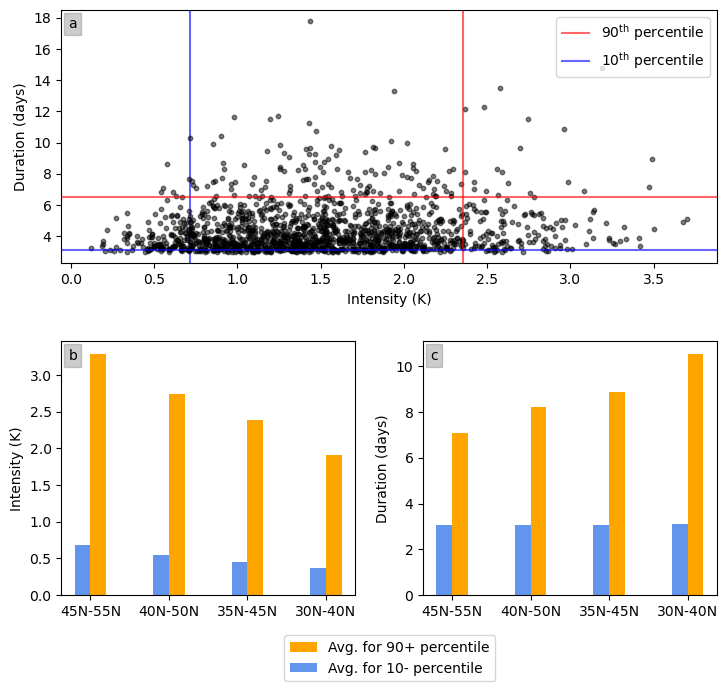

In [3]:
# Global warming
output_dir = '/home/data/lab_project2/Steve/model_runs/dry_land/scratch/'


import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

fig=pl.figure(figsize=(7.5, 7))
ax1 = pl.subplot(gs[1, 0]) # row 0, col 0

ax2 = pl.subplot(gs[1, 1]) # row 0, col 1


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms

with open(output_dir+'hw_50', 'rb') as f:
    heat_index1= pickle.load(f)
with open(output_dir+'hw_45', 'rb') as f:
    heat_index2= pickle.load(f)
with open(output_dir+'hw_40', 'rb') as f:
    heat_index3= pickle.load(f)
with open(output_dir+'hw_35', 'rb') as f:
    heat_index4= pickle.load(f)

    
def set_label(fig, ax, label):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily=None,
            bbox=dict(color='grey', facecolor='1', edgecolor='none', pad=3.0, alpha=0.4))

##################### selecting the target longitude patches ##############

target_lons = np.arange(5, 355, 70)

hw_master = heat_index1
mask = [lon in target_lons for lon in hw_master['lonc']]
hw_master = {key: [vals[i] for i, m in enumerate(mask) if m]
               for key, vals in hw_master.items()}
heat_index1 = hw_master

hw_master = heat_index2
mask = [lon in target_lons for lon in hw_master['lonc']]
hw_master = {key: [vals[i] for i, m in enumerate(mask) if m]
               for key, vals in hw_master.items()}
heat_index2 = hw_master

hw_master = heat_index3
mask = [lon in target_lons for lon in hw_master['lonc']]
hw_master = {key: [vals[i] for i, m in enumerate(mask) if m]
               for key, vals in hw_master.items()}
heat_index3 = hw_master

hw_master = heat_index4
mask = [lon in target_lons for lon in hw_master['lonc']]
hw_master = {key: [vals[i] for i, m in enumerate(mask) if m]
               for key, vals in hw_master.items()}
heat_index4 = hw_master

###########################################################################

int_list1=heat_index1['intensity']
dur_list1=heat_index1['duration']
int_list2=heat_index2['intensity']
dur_list2=heat_index2['duration']
int_list3=heat_index3['intensity']
dur_list3=heat_index3['duration']
int_list4=heat_index4['intensity']
dur_list4=heat_index4['duration']


dur1l=[];dur1h=[]
int1l=[];int1h=[]

dur2l=[];dur2h=[]
int2l=[];int2h=[]

dur3l=[];dur3h=[]
int3l=[];int3h=[]

dur4l=[];dur4h=[]
int4l=[];int4h=[]

cut=np.quantile(dur_list1,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list1)):
    if (dur_list1[i]>=cut[0]  and dur_list1[i]<=cut[1]):
        dur1l.append(dur_list1[i])
    if (dur_list1[i]>=cut[4]  and dur_list1[i]<=cut[5]):
        dur1h.append(dur_list1[i])

cut=np.quantile(int_list1,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list1)):
    if (int_list1[i]>=cut[0]  and int_list1[i]<=cut[1]):
        int1l.append(int_list1[i])
    if (int_list1[i]>=cut[4]  and int_list1[i]<=cut[5]):
        int1h.append(int_list1[i])
    
##########################################################################
cut=np.quantile(dur_list2,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list2)):
    if (dur_list2[i]>=cut[0]  and dur_list2[i]<=cut[1]):
        dur2l.append(dur_list2[i])
    if (dur_list2[i]>=cut[4]  and dur_list2[i]<=cut[5]):
        dur2h.append(dur_list2[i])

cut=np.quantile(int_list2,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list2)):
    if (int_list2[i]>=cut[0]  and int_list2[i]<=cut[1]):
        int2l.append(int_list2[i])
    if (int_list2[i]>=cut[4]  and int_list2[i]<=cut[5]):
        int2h.append(int_list2[i])
        

##########################################################################
cut=np.quantile(dur_list3,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list3)):
    if (dur_list3[i]>=cut[0]  and dur_list3[i]<=cut[1]):
        dur3l.append(dur_list3[i])
    if (dur_list3[i]>=cut[4]  and dur_list3[i]<=cut[5]):
        dur3h.append(dur_list3[i])

cut=np.quantile(int_list3,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list3)):
    if (int_list3[i]>=cut[0]  and int_list3[i]<=cut[1]):
        int3l.append(int_list3[i])
    if (int_list3[i]>=cut[4]  and int_list3[i]<=cut[5]):
        int3h.append(int_list3[i])
        
##########################################################################
cut=np.quantile(dur_list4,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list4)):
    if (dur_list4[i]>=cut[0]  and dur_list4[i]<=cut[1]):
        dur4l.append(dur_list4[i])
    if (dur_list4[i]>=cut[4]  and dur_list4[i]<=cut[5]):
        dur4h.append(dur_list4[i])

cut=np.quantile(int_list4,[0,0.1,0.45,0.55,0.9,1])

for i in range(len(dur_list4)):
    if (int_list4[i]>=cut[0]  and int_list4[i]<=cut[1]):
        int4l.append(int_list4[i])
    if (int_list4[i]>=cut[4]  and int_list4[i]<=cut[5]):
        int4h.append(int_list4[i])


x = np.arange(4) 
y1 = [np.mean(int1l), np.mean(int2l), np.mean(int3l), np.mean(int4l)] 
y2 = [np.mean(int1h), np.mean(int2h), np.mean(int3h), np.mean(int4h)] 
width = 0.2
  
# plot data in grouped manner of bar type 
ax1.bar(x+0.1, y2, width, color='orange') 
ax1.bar(x-0.1, y1, width, color='cornflowerblue') 
ax1.set_xticks(x, ['45N-55N', '40N-50N', '35N-45N', '30N-40N']) 
ax1.set_ylabel("Intensity (K)") 
set_label(fig, ax1,'b')


x = np.arange(4) 
y1 = [np.mean(dur1l), np.mean(dur2l), np.mean(dur3l), np.mean(dur4l)] 
y2 = [np.mean(dur1h), np.mean(dur2h), np.mean(dur3h), np.mean(dur4h)] 

width = 0.2

ax2.bar(x+0.1, y2, width, color='orange') 
ax2.bar(x-0.1, y1, width, color='cornflowerblue') 
ax2.set_xticks(x, ['45N-55N', '40N-50N', '35N-45N', '30N-40N']) 
ax2.set_ylabel("Duration (days)") 
set_label(fig, ax2,'c')


pl.legend(["Avg. for 90+ percentile", "Avg. for 10- percentile"], bbox_to_anchor=(0.27, -0.13)) 

###########################################################
###########################################################
ax = pl.subplot(gs[0, :]) # row 1, span all columns
set_label(fig, ax,'a')
import seaborn as sns
import scipy.stats
from scipy import interpolate

with open(output_dir+'hw_45', 'rb') as f:
    heat_index= pickle.load(f)

target_lons = np.arange(5, 355, 70)
hw_master = heat_index
mask = [lon in target_lons for lon in hw_master['lonc']]
hw_master = {key: [vals[i] for i, m in enumerate(mask) if m]
               for key, vals in hw_master.items()}
heat_index = hw_master

int_list=heat_index['intensity']
dur_list=heat_index['duration']

pni,pmi=np.quantile(int_list,[0.1,0.9])
ax.axvline(pni,color='blue',alpha=0.6, zorder=1)
ax.axvline(pmi,color='red',alpha=0.6, label=r'90$^{\mathrm{th}}$ percentile', zorder=2)
pnd,pmd=np.quantile(dur_list,[0.1,0.9])
ax.axhline(pnd,color='blue',alpha=0.6, label=r'10$^{\mathrm{th}}$ percentile', zorder=3)
ax.axhline(pmd,color='red',alpha=0.6, zorder=4)

ax.scatter(int_list, dur_list,s=10,color='black', alpha=0.5)

ax.set_xlabel('Intensity (K)')
ax.set_ylabel('Duration (days)')
ax.legend()
plt.tight_layout(h_pad=2.5, w_pad=-6)

fig.savefig('/home/data/lab_project2/Steve/model_runs/plotting/dl-plots/1.pdf', bbox_inches='tight')
fig.savefig('/home/data/lab_project2/Steve/model_runs/plotting/dl-plots/1.jpg',dpi=600, bbox_inches='tight')